# **Detección de incendios forestales mediante red neuronal convolucional Arquitectura EffientNet**

---


El obejetivo del Script es porder diferenciar entre una imagen que muestra un bosque con fuego de una imagen de un bosque sin fuego. Utlizaremos Redes Neuronales Convolucionales (CNN) con Arquitectura EffientNet.

link al dataset: https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data

Importamos librerias necesarias
Ysaremos las librerias keras de la biblioteca TensorFlow. Keras es una popular biblioteca de aprendizaje profundo escrita en Python que proporciona una interfaz de alto nivel para diseñar, entrenar y evaluar modelos de redes neuronales. Keras se ha integrado con TensorFlow lo que significa que puedes utilizar Keras como una API de alto nivel para construir y entrenar modelos de TensorFlow. 


---


In [62]:
# Importamos las librerías
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications, optimizers
import matplotlib.pyplot as plt

import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

Separamos el datasets en training y testing

In [6]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

X_train = train.flow_from_directory("C:/Users/Fer/Documents/Python/fire/TrainingandValidation",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
X_test = test.flow_from_directory("C:/Users/Fer/Documents/Python/fire/Testing",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')



Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [7]:
test_dataset.class_indices

{'fire': 0, 'nofire': 1}


**Task: clasificación de imágenes.**

Nuestro problema consiste en clasificar las distintas imágenes que vayamos presentando a nuestra red neuronal.

Para realizar esta tarea, utilizaremos una arquitectura de tipo `EfficientNet`. Esta red neuronal es muy famosa por ser capaz de distinguir distintas imágenes con un grado de acierto muy alto.

In [8]:
#Configuramos nuestra red neuronal
LR = 0.002
EPOCHS = 10
BATCH = 128
CLASES = 10

#4. Preprocesamos las imagenes
X_train = applications.efficientnet.preprocess_input(X_train)
X_test = applications.efficientnet.preprocess_input(X_test)

`NOTAS: `

La función **applications.efficientnet.preprocess_input()** es una función de preprocesamiento específica para el modelo EfficientNet. 

**EfficientNet** es una arquitectura de CNN que ha demostrado un rendimiento excepcional en tareas de clasificación de imágenes.

La función preprocess_input() se utiliza para realizar el preprocesamiento de las imágenes de entrada antes de pasarlas al modelo EfficientNet. Este preprocesamiento puede incluir normalización, cambio de escala y otras transformaciones necesarias para adaptar las imágenes al formato requerido por el modelo.

Es importante tener en cuenta que cada modelo puede tener su propia función de preprocesamiento específica. Por lo tanto, el uso de preprocess_input() puede variar dependiendo del modelo que estés utilizando. 

In [9]:
inputs = layers.Input(shape=(32,32,3))

#tenemos imagenes de dimensión 32x32x3, pero la red trabaja mejor con imágenes de dimensión 224x224x3
#implementamos una función que redimensione las imágenes del dataset.
upscale = layers.Lambda(lambda x: tf.image.resize_with_pad(x,224,224,method=tf.image.ResizeMethod.BILINEAR))(inputs)

`NOTAS`:

`upscale` es un tensor resultante de aplicar una transformación a inputs. En particular, se utiliza la función **tf.image.resize_with_pad()** de TensorFlow para redimensionar y rellenar las imágenes de entrada.

El código anterior se encarga de aplicar esta transformación. 

**layers.Lambda(lambda x: ...)**: crea una capa lambda en Keras que permite aplicar una función personalizada a los datos de entrada.

**tf.image.resize_with_pad()** es una función de TensorFlow que redimensiona una imagen de entrada manteniendo su relación de aspecto original y, si es necesario, realiza un relleno para ajustar la imagen a la forma deseada. En este caso, la función se utiliza para redimensionar las imágenes a una forma de (224, 224) y utiliza el método de interpolación bilineal para realizar el redimensionamiento.

In [10]:
#5. Cargamos la arquitectura ya entrenada de Efficientnet
modelo = applications.EfficientNetB0(include_top=False,  
                                     weights="imagenet",
                                     input_tensor = upscale, 
                                     input_shape=(224, 224, 3))

# si include_top=False ---> eliminamos el head de la red neuronal (nos quedan 239 capas)
# si include_top=True ---> cargamos toda la red (242 capas)

print(f"--> Número total de capas:{len(modelo.layers)}")
# modelo.summary()

16705208/16705208 [==============================] - 19s 1us/step
--> Número total de capas:239


`NOTAS`:

Creamos una instancia del modelo EfficientNetB0 utilizando la función **applications.EfficientNetB0()** de Keras. Veamos los argumentos utilizados en la creación del modelo:

`include_top=False`: indica que no se deben incluir las capas totalmente conectadas (top) en el modelo. Al establecerlo en False, se descartan las capas finales del modelo que están diseñadas para la clasificación de imágenes en un conjunto de clases específico. Esto es útil si deseas utilizar el modelo para transferir aprendizaje y agregar tus propias capas personalizadas al final.

`weights="imagenet"`: indica que se deben cargar los pesos pre-entrenados del modelo EfficientNetB0 entrenado en el conjunto de datos ImageNet. Estos pesos pre-entrenados se descargan automáticamente si no están disponibles localmente.

`input_tensor=upscale`: especifica el tensor de entrada del modelo. 

`input_shape=(224, 224, 3)`: define la forma del tensor de entrada. En este caso se espera que las imágenes de entrada tengan una forma de (224, 224, 3), lo que indica una resolución de 224x224 píxeles y 3 canales de color (RGB).

Una vez creado el modelo EfficientNetB0 se puede utilizar para realizar tareas como extracción de características o transferencia de aprendizaje en tus propios conjuntos de datos. 

Agregaremos las capas de clasificación o regresión en la parte superior del modelo para adaptarlo a nuestra tarea específica.

In [11]:
# freezamos todas las capas para que no se entrenen. 
# esta arquitectura cuenta con 239 capas (porque eliminamos las últimas)

for layer in modelo.layers: 
  layer.trainable = False

In [12]:
# añadiremos algunas capas que serán las únicas que entrenaremos
extractor_características = modelo.output

#añadimos dos capas
maxpool = layers.GlobalMaxPooling2D()(extractor_características)
ultima_capa = layers.Dense(CLASES, activation="softmax")(maxpool)

#creamos el modelo
modelo_tl = models.Model(inputs=inputs, outputs=ultima_capa)

#definimos el optimizador
opt = optimizers.Adam(learning_rate=LR)

#compilamos el modelo
modelo_tl.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


No vamos a usar datos de validación, sólo de entrenamiento y testeo

In [14]:
# entrenamos el modelo y guardamos el history
#history = modelo_tl.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, y_test))

# entrenamos el modelo y guardamos el history
history = modelo_tl.fit(X_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test))

Epoch 1/10
58/58 [==============================] - 141s 2s/step - loss: 0.9851 - sparse_categorical_accuracy: 0.4973 - val_loss: 0.7718 - val_sparse_categorical_accuracy: 0.3235
Epoch 2/10
58/58 [==============================] - 115s 2s/step - loss: 0.7557 - sparse_categorical_accuracy: 0.4967 - val_loss: 0.7455 - val_sparse_categorical_accuracy: 0.3235
Epoch 3/10
58/58 [==============================] - 114s 2s/step - loss: 0.7456 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.4211 - val_sparse_categorical_accuracy: 0.3235
Epoch 4/10
58/58 [==============================] - 115s 2s/step - loss: 0.8628 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.4687 - val_sparse_categorical_accuracy: 0.3235
Epoch 5/10
58/58 [==============================] - 115s 2s/step - loss: 0.8750 - sparse_categorical_accuracy: 0.5082 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.3235
Epoch 6/10
58/58 [==============================] - 103s 2s/step - loss: 0.7388 - sparse_categorical_accu

In [70]:
predictions = modelo_tl.predict(X_test)
predictions = np.round(predictions)

3/3 [==============================] - 3s 871ms/step


In [71]:
predictions

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [72]:
print(len(predictions))

68


Grafico de Perdida por Iteracion

"loss" (pérdida) y "val_loss" (pérdida de validación) son métricas utilizadas para medir el error del modelo durante el entrenamiento y la evaluación.

La "loss" o pérdida es una medida de la discrepancia entre las predicciones del modelo y los valores reales en el conjunto de entrenamiento. Indica cuánto se equivoca el modelo en cada predicción. El objetivo durante el entrenamiento es minimizar esta pérdida, es decir, ajustar los parámetros del modelo para que las predicciones se acerquen lo más posible a los valores reales. 
El "val_loss" o pérdida de validación es similar a la pérdida, pero se calcula utilizando un conjunto de datos de validación independiente que no se utiliza durante el entrenamiento. El "val_loss" proporciona una medida de cómo se desempeña el modelo en datos no vistos previamente y es una métrica útil para evaluar la capacidad de generalización del modelo. El objetivo es que tanto la pérdida como el "val_loss" sean lo más bajos posible, lo que indica un mejor ajuste del modelo a los datos.

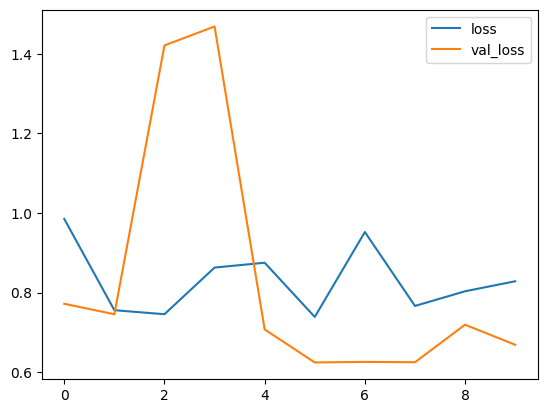

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

Grafico de Accuracy por Iteracion

El "accuracy" representa la proporción de predicciones correctas realizadas por el modelo en relación con el número total de muestras. Se calcula dividiendo el número de predicciones correctas entre el número total de muestras en el conjunto de datos. Es una métrica comúnmente utilizada para evaluar modelos de clasificación.

El "val accuracy" o exactitud de validación es similar al accuracy, pero se calcula utilizando un conjunto de datos de validación independiente que no se utiliza durante el entrenamiento del modelo. Este conjunto de datos de validación se utiliza para evaluar el rendimiento del modelo en datos no vistos previamente y para estimar cómo se generalizará a nuevos datos. 

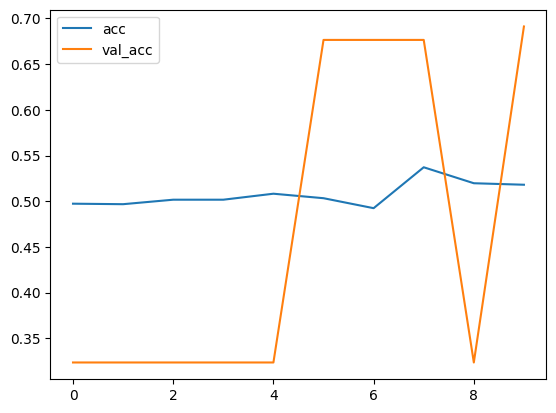

In [35]:
plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend()

**Resumen**: 

* Freezamos todas las capas (excepto el head, que no hemos cargado). Estas capas freezadas no serán entrenadas, simplemente actúan como un extractor de características. 

* Se usarán los pesos aprendidos (ajustados) cuando la red fue pre-entrenada con el dataset ImageNet.

* Añadimos 2 nuevas capas al final de todo (reemplazando el head original): una capa GlobalMaxPooling y una capa densa con 10 clases de salida (con “softmax” como función de activación).

GlobalMaxPooling2D de Keras: esta capa se utiliza comúnmente en CNN para realizar el proceso de "max pooling" global en la salida de la última capa convolucional. Calcula el valor máximo para cada canal en toda la imagen, lo que significa que toma el valor máximo de cada canal en la imagen completa y lo mantiene como resultado. Esto tiene el efecto de reducir la dimensionalidad del tensor de entrada a lo largo de las dimensiones espaciales, conservando solo la información más relevante y representativa.

La principal diferencia entre **GlobalMaxPooling2D** y **MaxPooling2D** radica en las dimensiones sobre las cuales se realiza la operación de "max pooling".

*MaxPooling2D* se aplica en ventanas locales dentro de la imagen de entrada y realiza una reducción espacial, es decir, reduce las dimensiones espaciales (alto y ancho) de la imagen, manteniendo los canales intactos. Por lo general, se utiliza para extraer características locales y reducir la resolución espacial de la salida de las capas convolucionales anteriores.

*GlobalMaxPooling2D* realiza una reducción global, considerando la imagen completa en lugar de ventanas locales. En lugar de aplicar la operación de "max pooling" a regiones locales, GlobalMaxPooling2D selecciona el valor máximo a lo largo de todas las dimensiones espaciales para cada canal. Esto reduce aún más la dimensionalidad espacial a un solo valor por canal, conservando solo la característica más relevante en cada canal.

MaxPooling2D es comúnmente utilizado dentro de la arquitectura de la red convolucional, mientras que GlobalMaxPooling2D se utiliza a menudo en la parte final de la red para capturar características globales antes de la capa de salida.

* Obserbamos que con tan solo 3 epcohs hemos conseguido una accuracy > 85%,  lo cual no está nada mal teniendo en cuenta la pobre calidad de las imágenes.